In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib as mpl

from intellect.io import load

import config

# to reduce size of the notebook
mpl.rcParams['figure.dpi']= 300
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 14
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 10)

In [2]:
asd = load(config.RANK_PRUNE_OUTPUT_DIR + f"baseline.csv", index_col=0)
baseline_all = asd.loc["All Traffic", "Original Accuracy"]
baseline_client = asd.loc["Client Traffic", "Original Accuracy"]
baseline_all, baseline_client

(0.9775778945096064, 0.981)

In [3]:
n_features = config.get_dataset()[0].n_features

In [4]:
IS_PAPER = False
def save(path):
    format = ".pdf" if IS_PAPER else ".png"
    dpi = None if IS_PAPER else 300
    mpl.pyplot.savefig(path + format, dpi=dpi)

In [20]:
def plot_sequential_elimination_outcome(all_categories=False):
    new_df = pd.DataFrame()
    p  = "all_c" if all_categories else "few_c"
    b = baseline_all if all_categories else baseline_client
    n = "with All Traffic Categories" if all_categories else "with Only Client Traffic"
    for p1 in ("iterative_rank", "fixed_rank"):
        for p2 in ("zero_first", "zero_not_first"):
            new_df[" ".join (x.capitalize() for x in p1.split("_")) + " and " + " ".join(x.capitalize() for x in p2.split("_"))] = load(config.RANK_PRUNE_OUTPUT_DIR + f"sequential_{p}_{p1}_{p2}.csv", index_col=0)["Accuracy"]
    ax = new_df.plot(alpha=0.8, style=['b:','r--','g-.','c-'], linewidth=2, ylabel="Accuracy")#title=f"Sequential Feature Elimination {n}"
    ax.legend(loc="lower left")
    ax.hlines(y=b, xmin=0, xmax=len(new_df), linestyles="dashed", linewidth=2, color='k')
    ax.invert_xaxis()
    ax.text(x=10, y=b-0.03, s="Baseline", c="k");
    save(config.RANK_PRUNE_OUTPUT_DIR + "sequential_elimination_outcome")


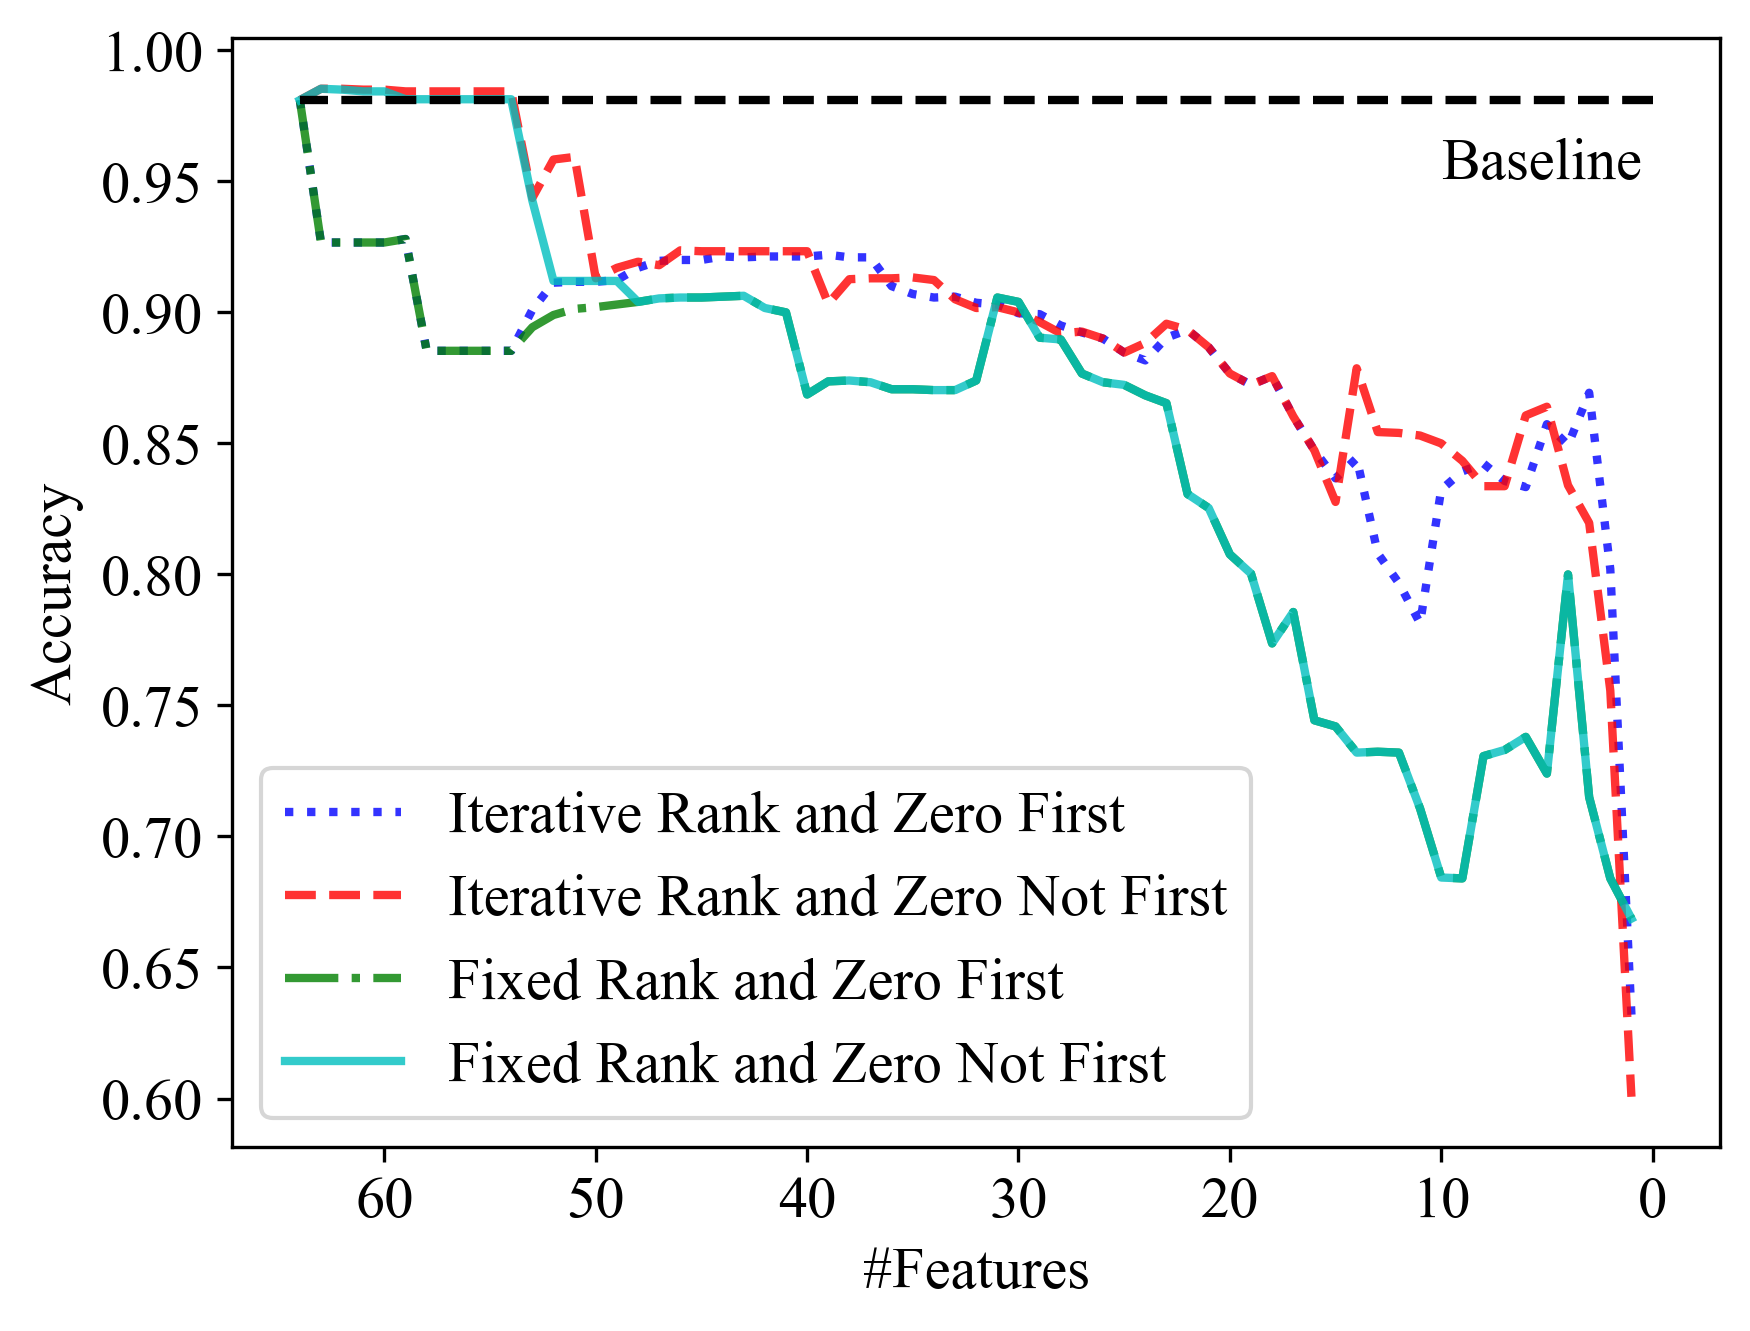

In [21]:
plot_sequential_elimination_outcome();

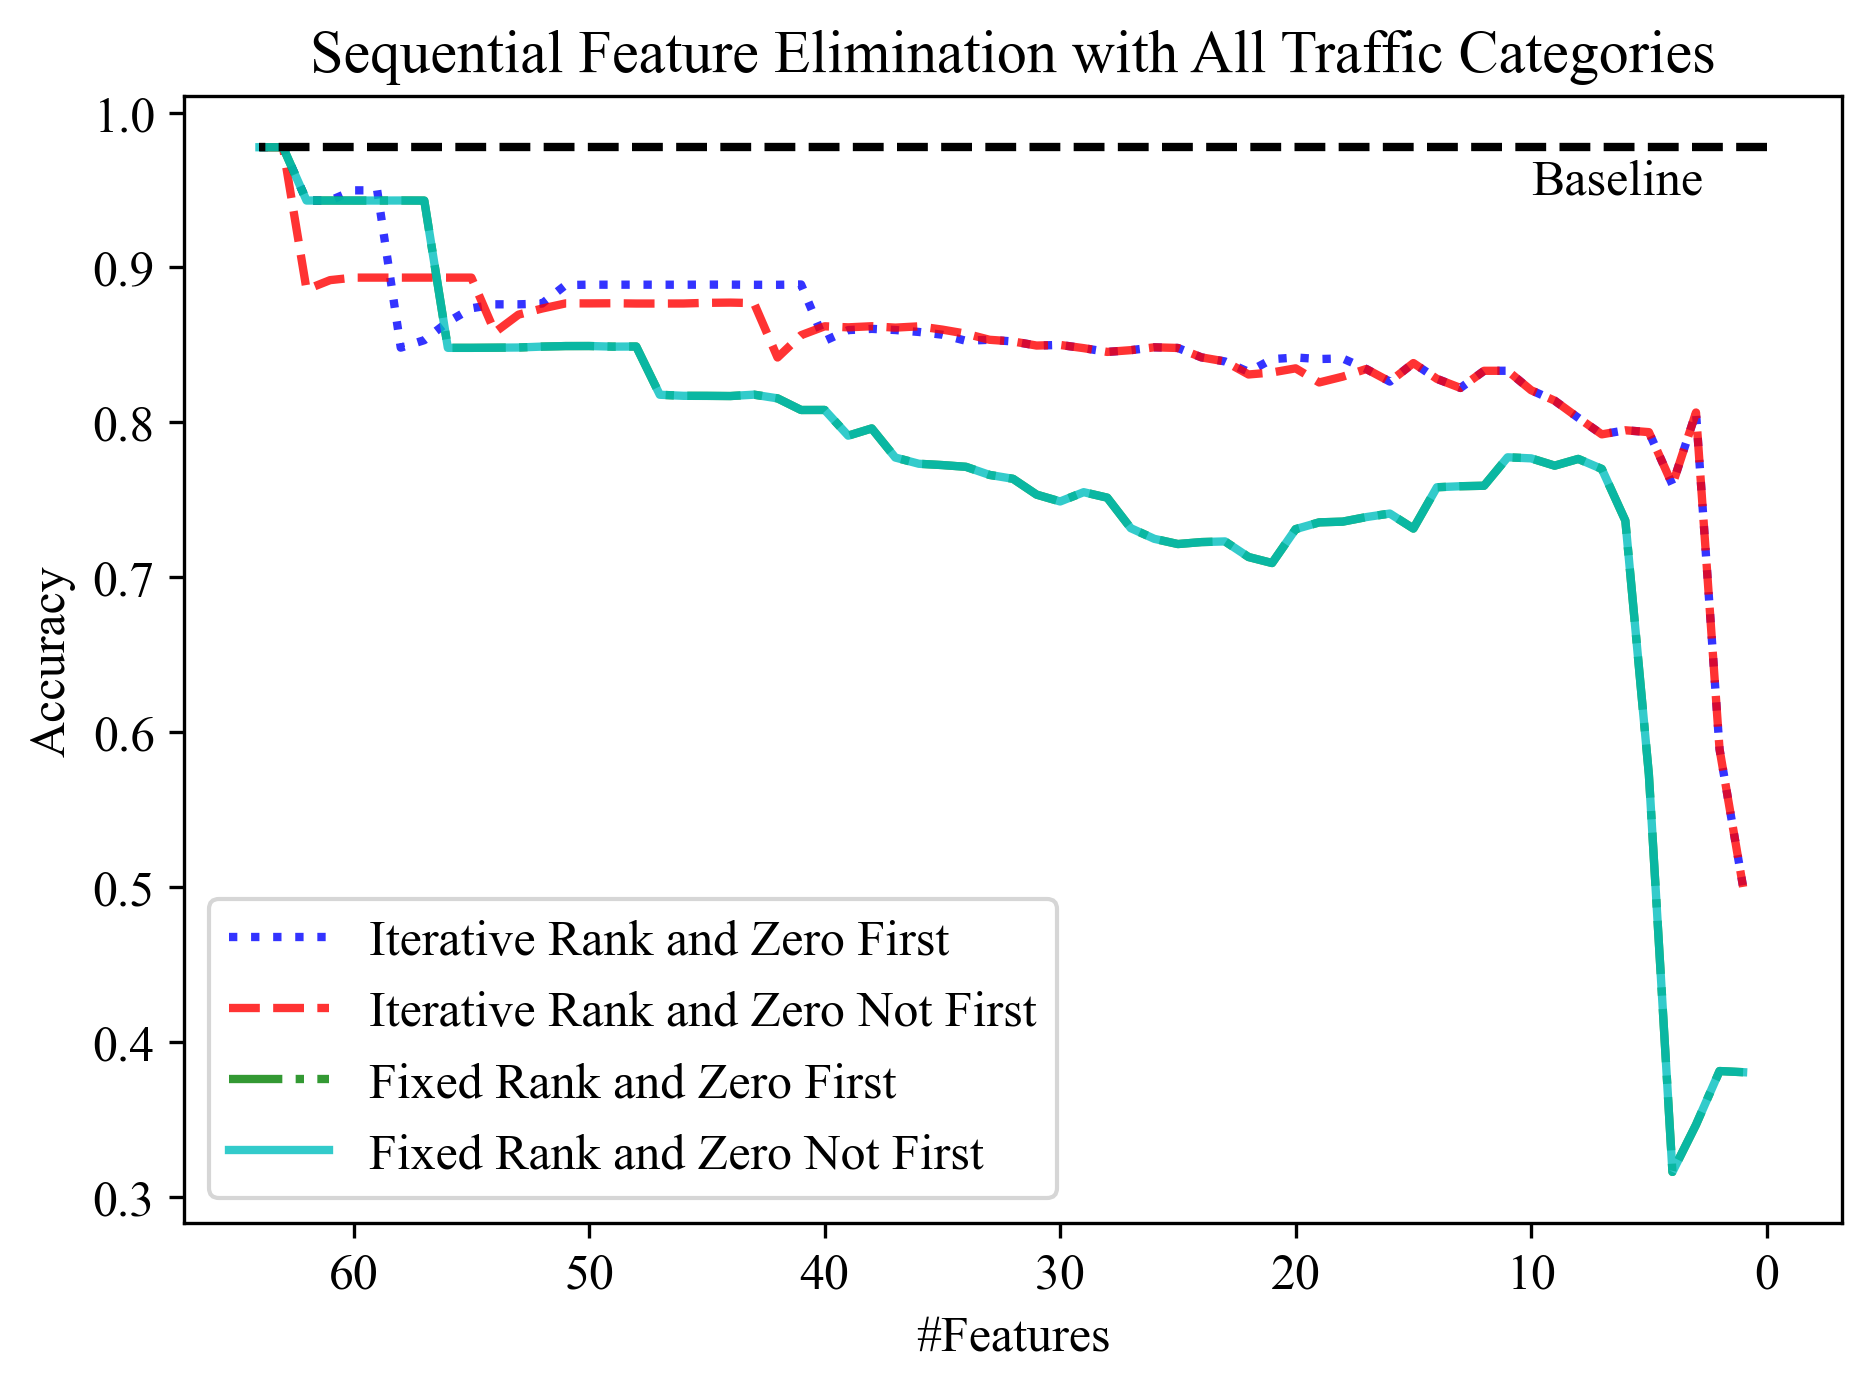

In [10]:
plot_sequential_elimination_outcome(all_categories=True);

In [18]:
def plot_different_pruning_methods(all_categories=True):
    p = "all_c" if all_categories else "few_c"
    l1: pd.DataFrame = load(config.RANK_PRUNE_OUTPUT_DIR + f"traffic_{p}_pruning_ratios_only_globally_unstructured_connections_l1.csv", index_col=0)
    random: pd.DataFrame = load(config.RANK_PRUNE_OUTPUT_DIR + "traffic_few_c_pruning_ratios_only_globally_unstructured_connections_random.csv", index_col=0)
    asd = pd.merge(l1, random, on='Prune Ratio', how="outer")
    ax = asd.plot.bar(x="Prune Ratio", ylabel="Accuracy", width=0.8, rot=0)#title="Pruning Algorithms Feasibility Analysis"
    ax.set_ylim(bottom=0.65, top=1)
    ax.legend(["L1-Norm", "Random"])
    ax.hlines(y=baseline_all, xmin=-1, xmax=11, linestyles="dashed", linewidth=2, color='r')
    ax.text(x=0, y=baseline_all+0.005, s="Baseline", c="r");
    mpl.pyplot.savefig(config.RANK_PRUNE_OUTPUT_DIR + "pruning_alg_comparison.pdf")


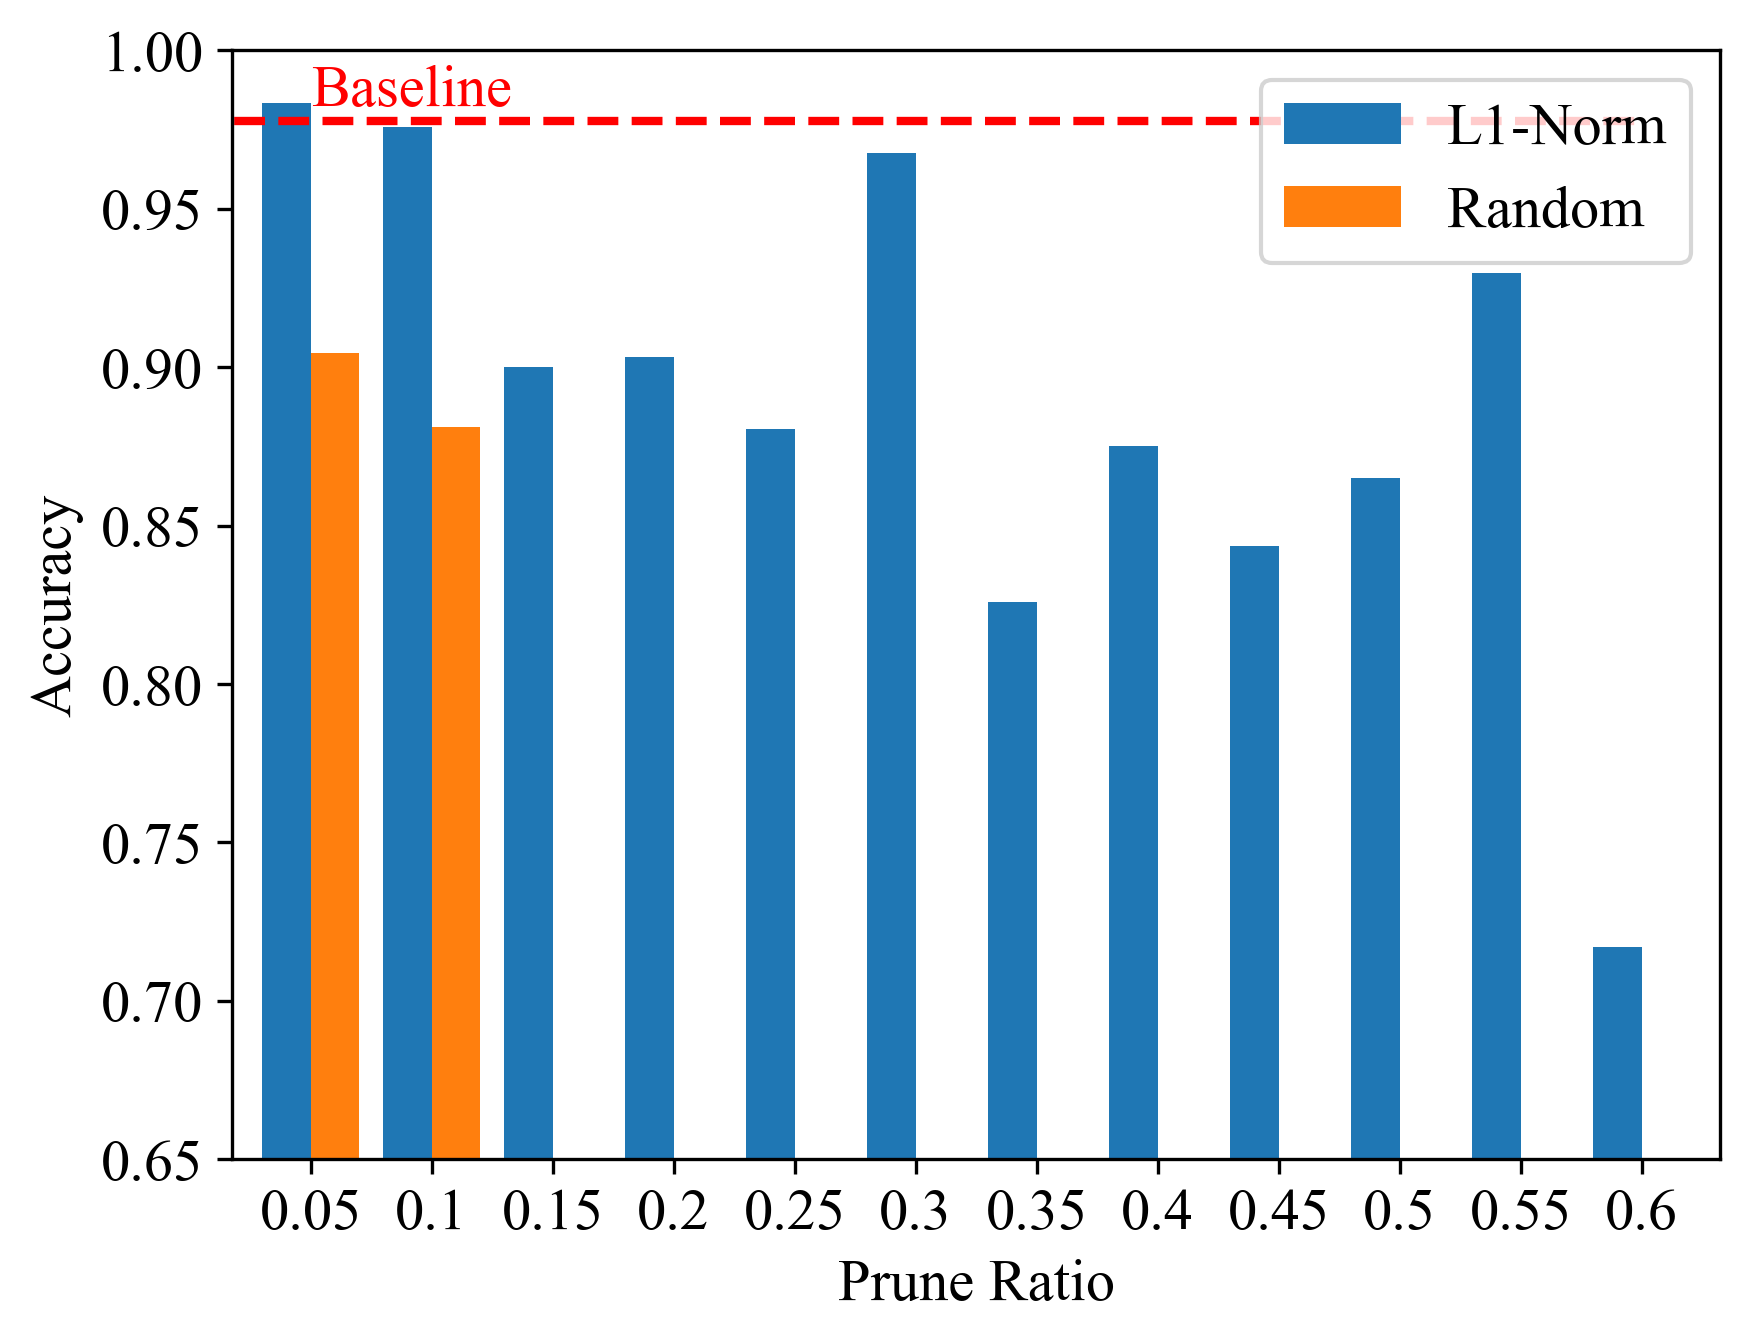

In [19]:
plot_different_pruning_methods(all_categories=False);

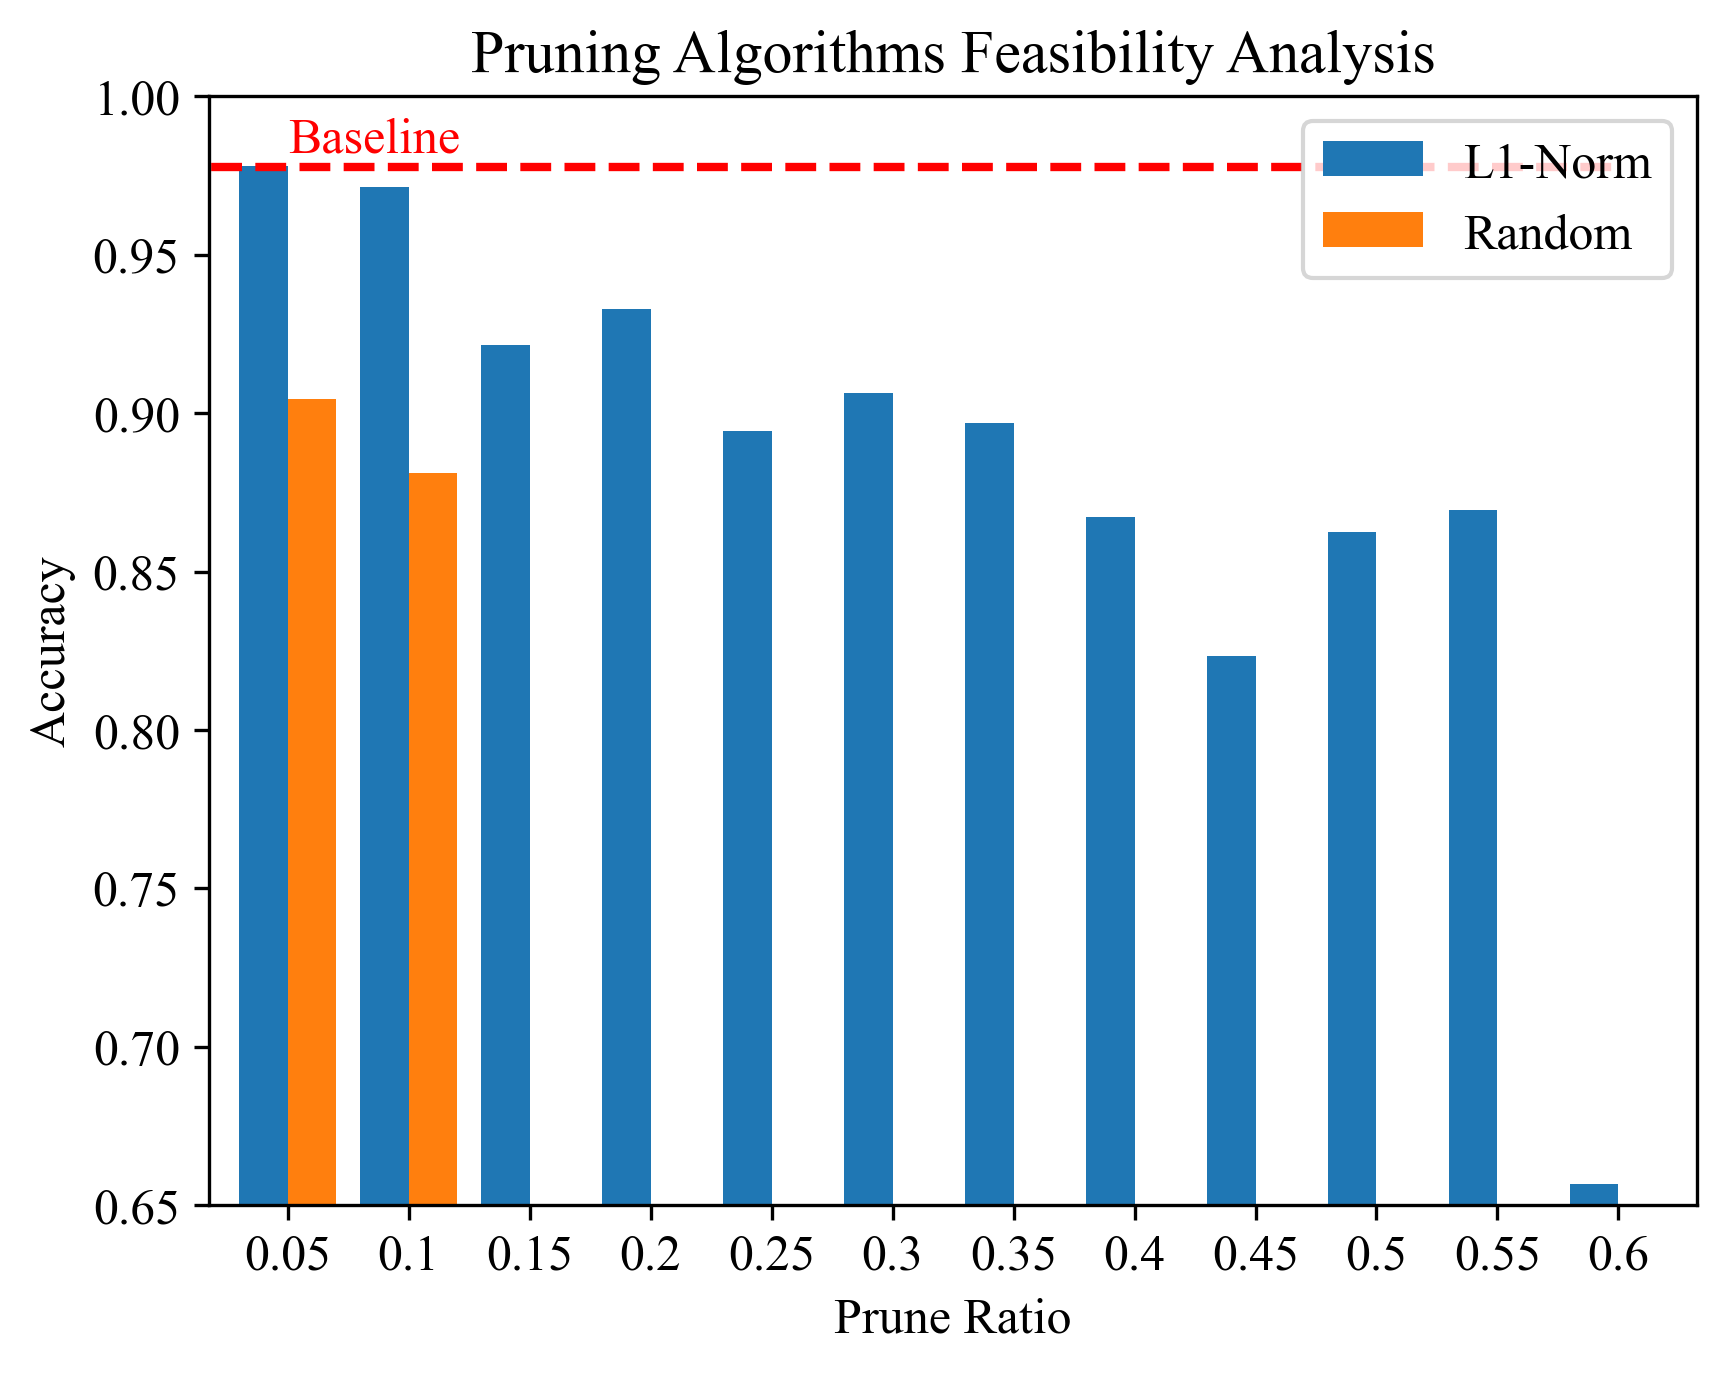

In [16]:
plot_different_pruning_methods(all_categories=True);

In [17]:
def plot_different_subsets_only_found(all_categories=False):
    p  = "all_c" if all_categories else "few_c"
    #b = baseline_all if all_categories else baseline_client
    #n = "with All Traffic Categories" if all_categories else "with Only Client Traffic"
    
    asd = pd.DataFrame({
        round(0.1*n_features): load(config.RANK_PRUNE_OUTPUT_DIR + f"rank_{p}_traffic_{p}_subsets_features_for_subsetsize_0.1.csv", index_col=0)["Accuracy"],
        round(0.3*n_features): load(config.RANK_PRUNE_OUTPUT_DIR + f"rank_{p}_traffic_{p}_subsets_features_for_subsetsize_0.3.csv", index_col=0)["Accuracy"],
        round(0.5*n_features): load(config.RANK_PRUNE_OUTPUT_DIR + f"rank_{p}_traffic_{p}_subsets_features_for_subsetsize_0.5.csv", index_col=0)["Accuracy"],
        round(0.8*n_features): load(config.RANK_PRUNE_OUTPUT_DIR + f"rank_{p}_traffic_{p}_subsets_features_for_subsetsize_0.8.csv", index_col=0)["Accuracy"],
    })
    ax = asd.boxplot(ylabel="Accuracy", xlabel="#Active Features (# feasible solutions)")
    ax.set_xticklabels([str(x) + f"\n({asd[x].notna().sum()})" for x in asd.columns])
    ax.set_title("Subset Search Feasibility")
    ax.hlines(y=baseline_all, xmin=1, xmax=4, linestyles="dashed", linewidth=2, color='r', label="Baseline")

    sz = [round(x*n_features) for x in config.TARGET_SUBSET_RATIOS]
    b = load(config.RANK_PRUNE_OUTPUT_DIR + f"sequential_{p}_iterative_rank_zero_not_first.csv", index_col=0).loc[sz, "Accuracy"].reset_index(drop=True)
    b.index += 1
    ax = b.plot(ax=ax, style="go:", label="Baseline RFE")
    ax.legend(loc="lower right")
    mpl.pyplot.tight_layout()
    mpl.pyplot.savefig(config.RANK_PRUNE_OUTPUT_DIR + "subset_search_feasibility.pdf", dpi=300)


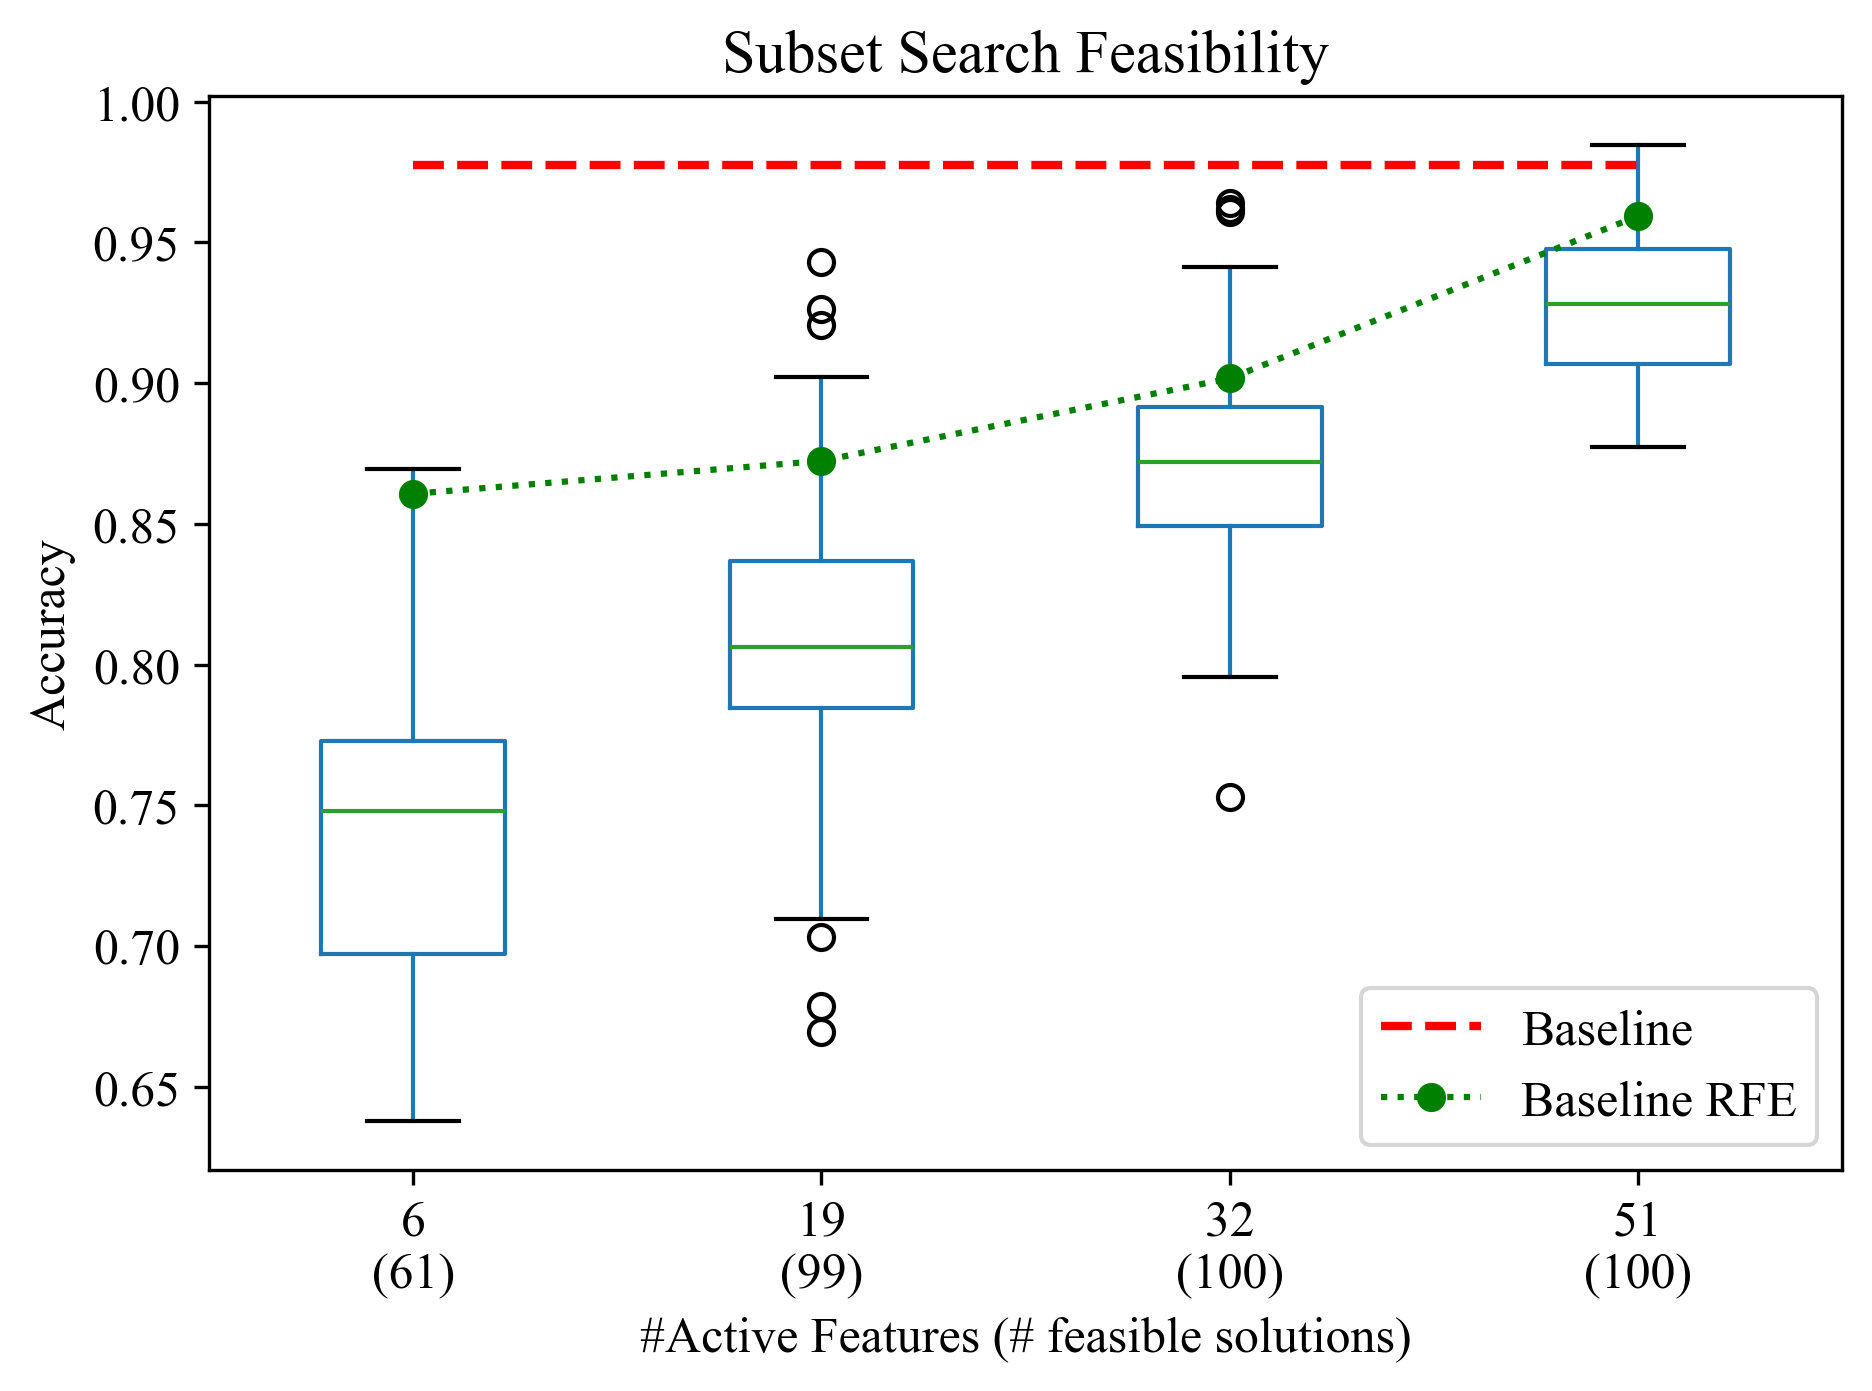

In [19]:
plot_different_subsets_only_found();

In [20]:
def plot_different_subsets_and_pruning(all_categories=False):
    p  = "all_c" if all_categories else "few_c"
    #b = baseline_all if all_categories else baseline_client
    #n = "with All Traffic Categories" if all_categories else "with Only Client Traffic"
    
    asd = pd.DataFrame({round(x*n_features): load(config.RANK_PRUNE_OUTPUT_DIR + f"rank_{p}_traffic_{p}_combo_subsets_features_pruned_models_for_subsetsize_{x}_{config.PRUNE_METHOD.__name__}.csv", index_col=0)["Accuracy"] for x in config.TARGET_SUBSET_RATIOS})
    asdone = pd.DataFrame({round(x*n_features): load(config.RANK_PRUNE_OUTPUT_DIR + f"rank_{p}_traffic_{p}_combo_subsets_features_pruned_models_for_subsetsize_{x}_{config.PRUNE_METHOD.__name__}.csv", index_col=0)["Prune Ratio"] for x in config.TARGET_SUBSET_RATIOS})
    ax = asd.boxplot(ylabel="Accuracy", xlabel="#Active Features (# Feasible Solutions)")
    ax.set_xticklabels([str(x) + f"\n({asd[x].notna().sum()})" + f"\n({asdone[y].nunique()})" for x,y in zip(asdone.columns, asd.columns)])
    ax.set_title("Subset Search Feasibility")
    ax.hlines(y=baseline_all, xmin=1, xmax=4, linestyles="dashed", linewidth=2, color='r', label="Baseline")

    sz = [round(x*n_features) for x in config.TARGET_SUBSET_RATIOS]
    b = load(config.RANK_PRUNE_OUTPUT_DIR + f"sequential_{p}_iterative_rank_zero_not_first.csv", index_col=0).loc[sz, "Accuracy"].reset_index(drop=True)
    b.index += 1
    ax = b.plot(ax=ax, style="go:", label="Baseline RFE", grid=True)
    ax.legend(loc="lower right")
    #mpl.pyplot.savefig(config.RANK_PRUNE_OUTPUT_DIR + "subset_prune_search_feasibility.pdf");


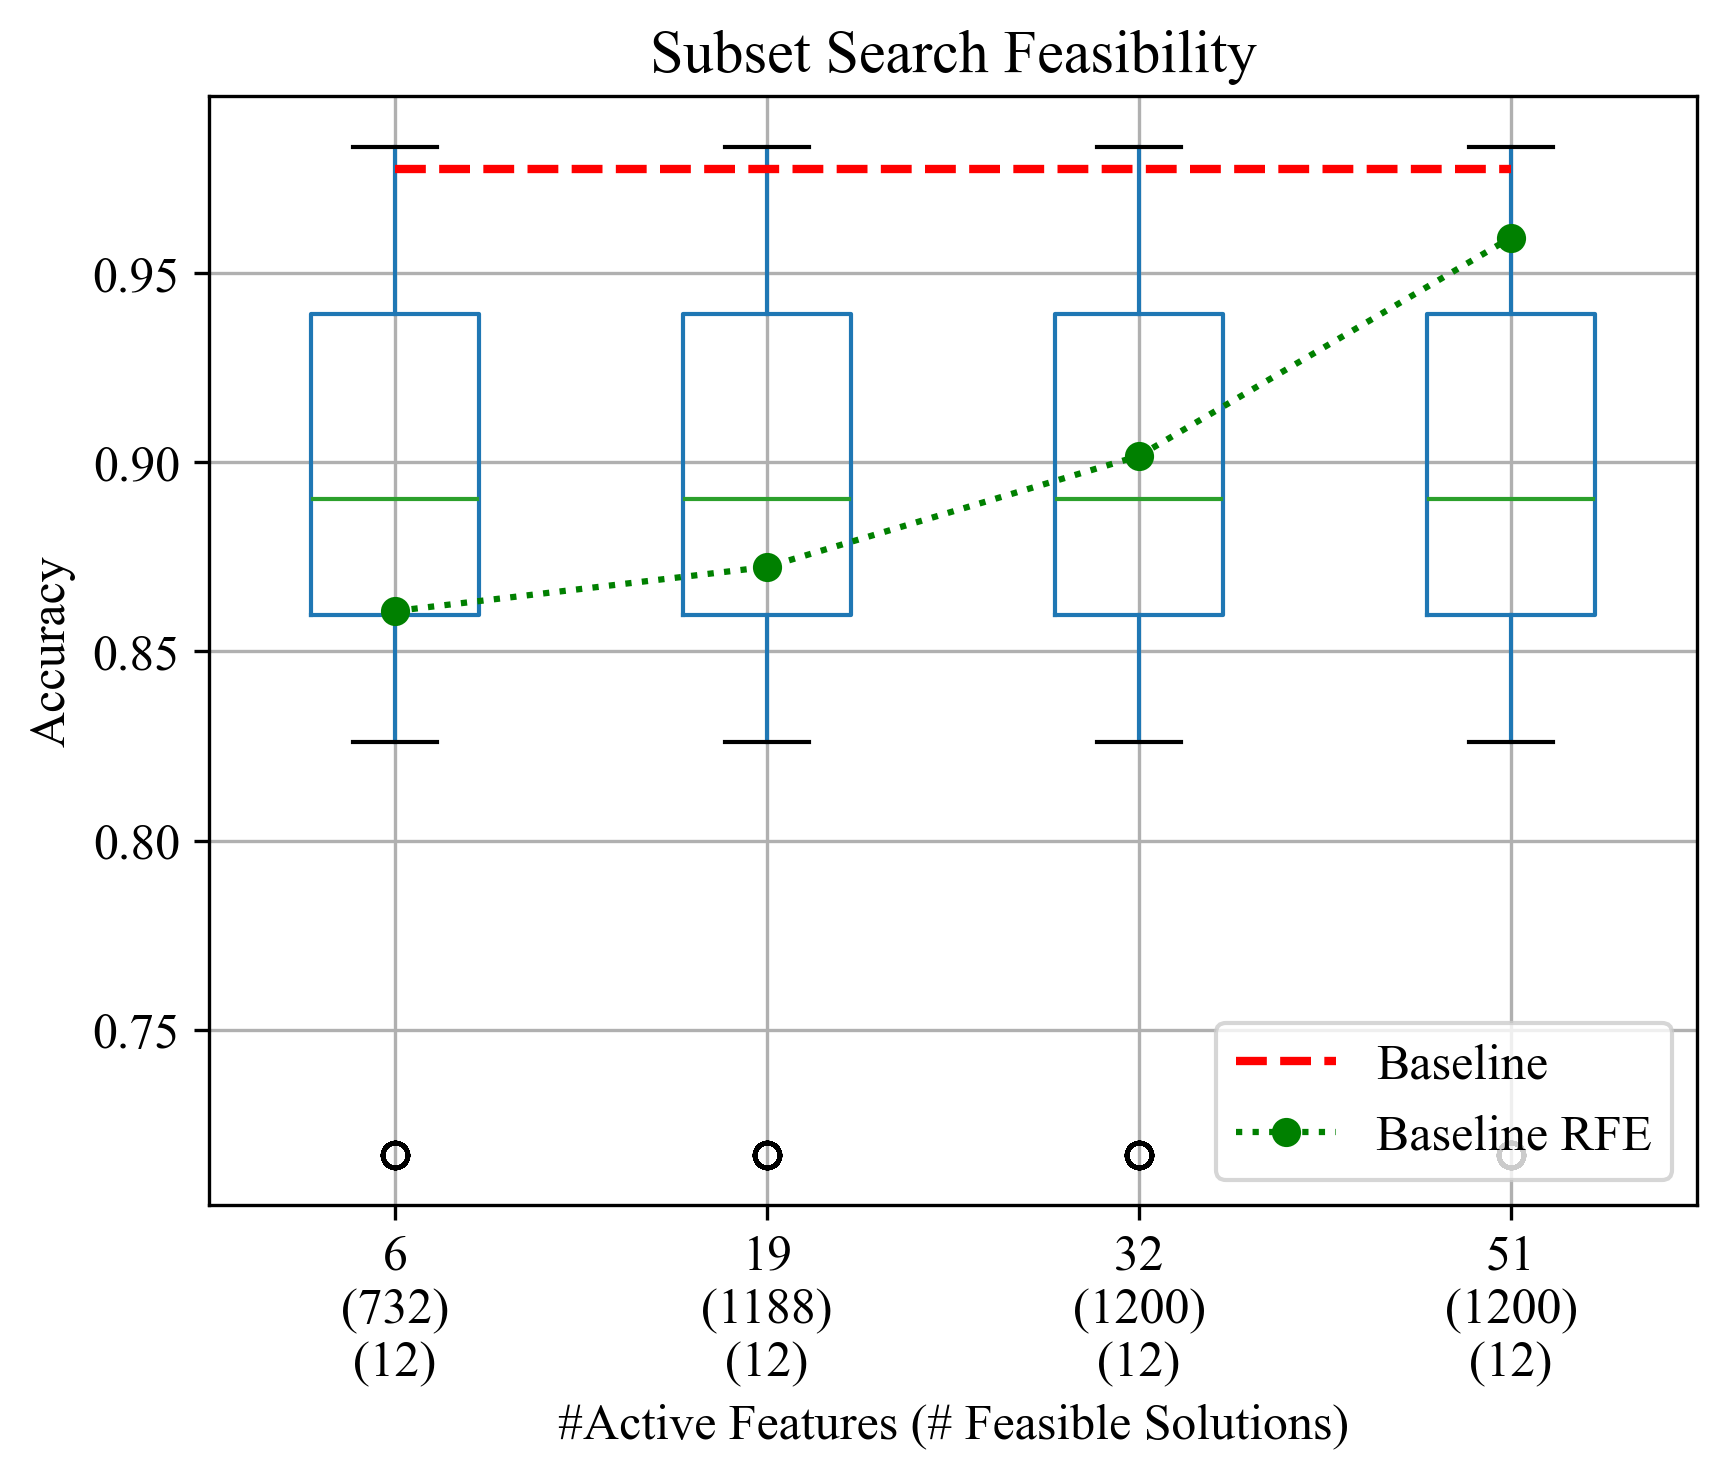

In [22]:
plot_different_subsets_and_pruning();

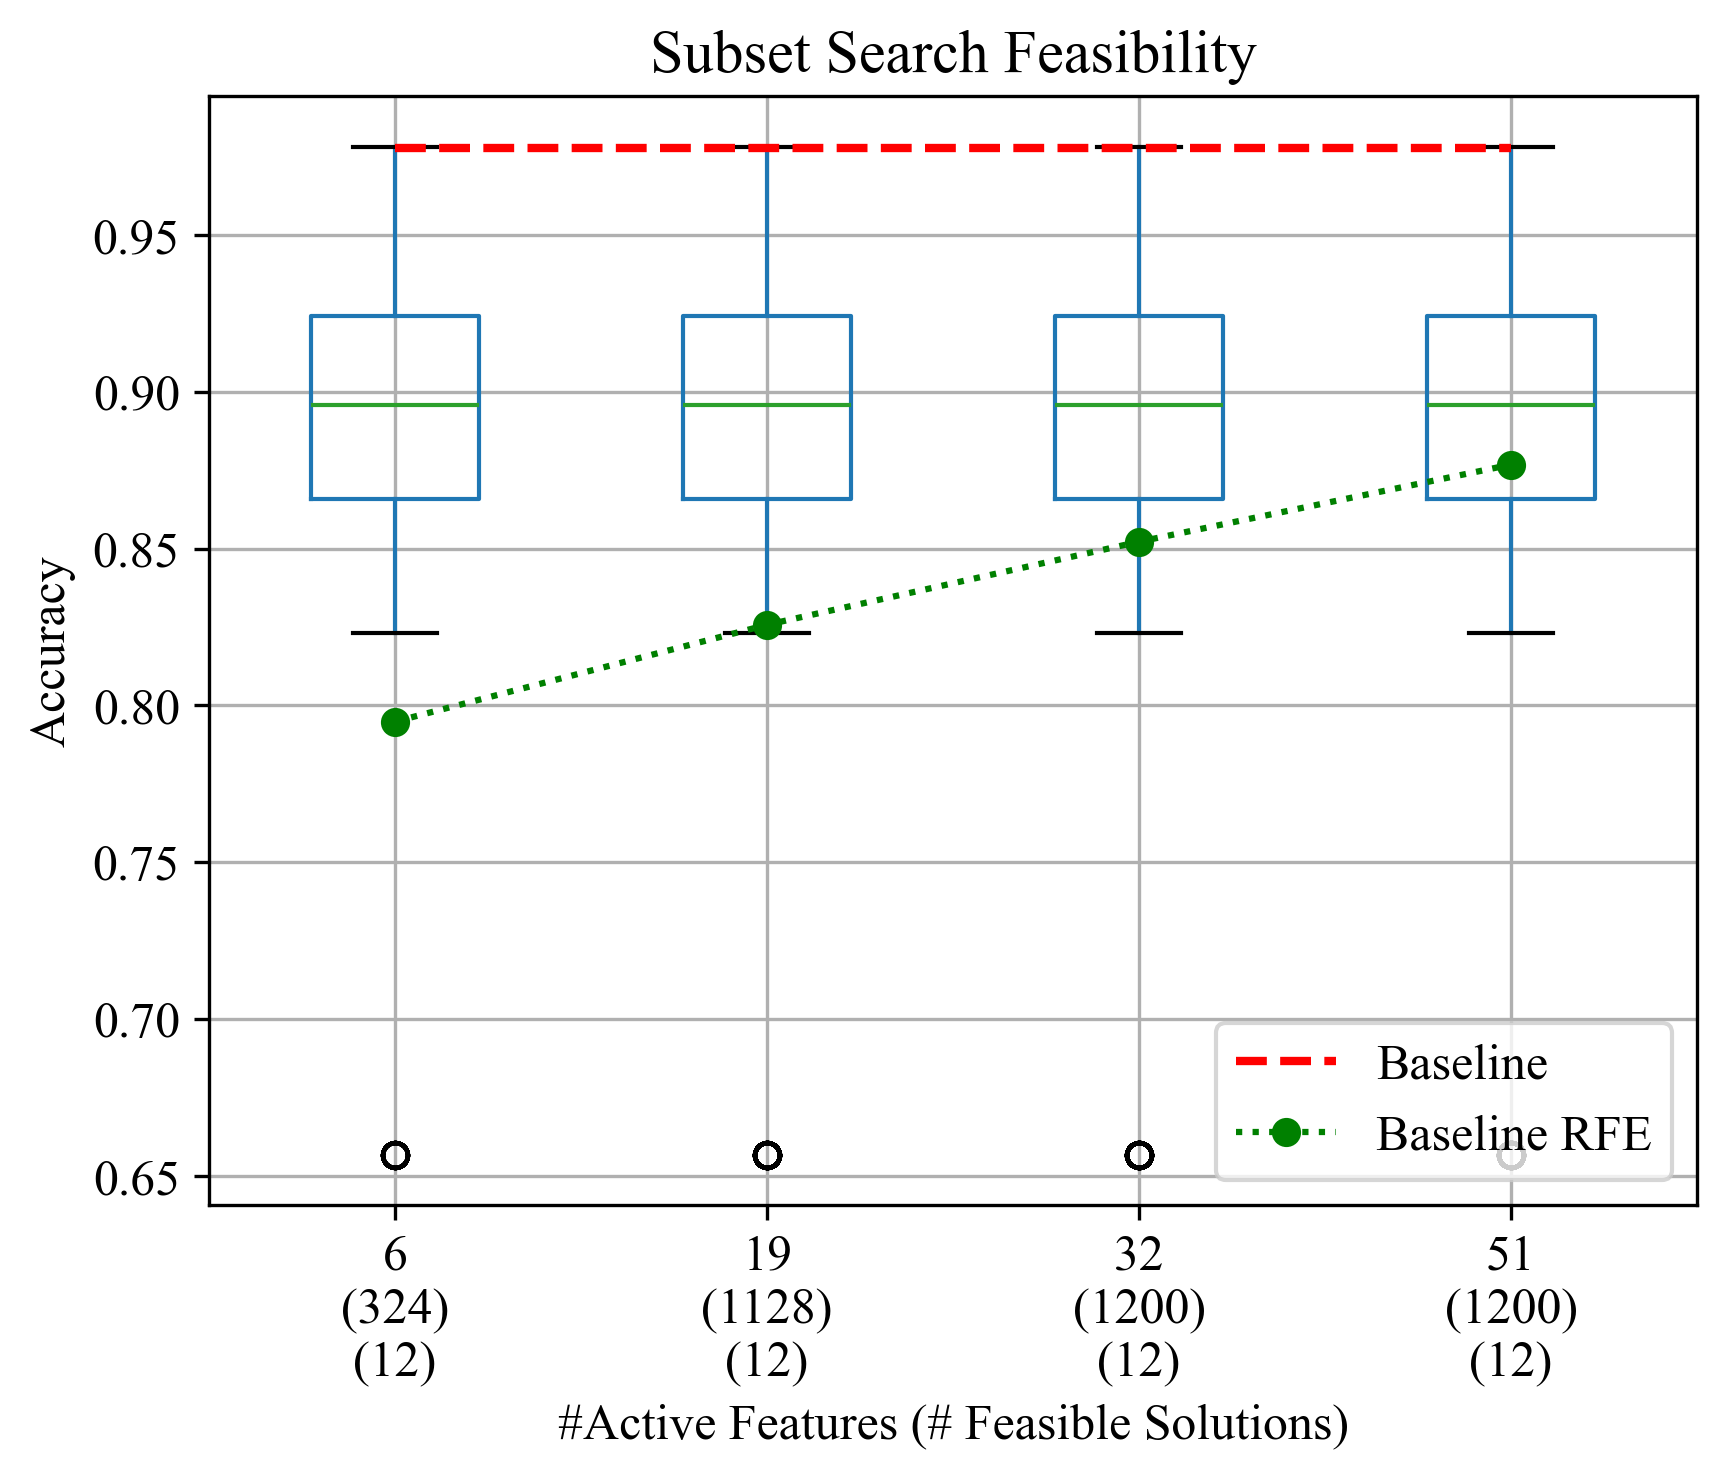

In [24]:
plot_different_subsets_and_pruning(all_categories=True);

In [16]:
def plot_different_pruning_and_subsets(all_categories=False):
    p  = "all_c" if all_categories else "few_c"
    #b = baseline_all if all_categories else baseline_client
    #n = "with All Traffic Categories" if all_categories else "with Only Client Traffic"
    
    asd = pd.DataFrame({round(x*n_features): load(config.RANK_PRUNE_OUTPUT_DIR + f"rank_{p}_traffic_{p}_combo_pruned_models_subsets_features_for_subsetsize_{x}_{config.PRUNE_METHOD.__name__}.csv", index_col=0)["Accuracy"] for x in config.TARGET_SUBSET_RATIOS})
    asdone = pd.DataFrame({round(x*n_features): load(config.RANK_PRUNE_OUTPUT_DIR + f"rank_{p}_traffic_{p}_combo_pruned_models_subsets_features_for_subsetsize_{x}_{config.PRUNE_METHOD.__name__}.csv", index_col=0)["Prune Ratio"] for x in config.TARGET_SUBSET_RATIOS})
    ax = asd.boxplot(ylabel="Accuracy", xlabel="# Features")
    #ax.set_title("Combining Model PruningSubset Search Feasibility")
    ax.hlines(y=baseline_all, xmin=1, xmax=4, linestyles="dashed", linewidth=2, color='r', label="Baseline")

    sz = [round(x*n_features) for x in config.TARGET_SUBSET_RATIOS]
    b = load(config.RANK_PRUNE_OUTPUT_DIR + f"sequential_{p}_iterative_rank_zero_not_first.csv", index_col=0).loc[sz, "Accuracy"].reset_index(drop=True)
    b.index += 1
    ax = b.plot(ax=ax, style="go:", label="Baseline Iterative", grid=True)
    ax.legend(loc="lower right")
    #ax.set_xticklabels([str(x) + f" - {asd[x].notna().sum()} - " + f"({asdone[x].nunique()})" for x in asd.columns.values])
    ax.invert_xaxis()
    mpl.pyplot.tight_layout()
    mpl.pyplot.savefig(config.RANK_PRUNE_OUTPUT_DIR + "subset_prune_subset_search_feasibility.pdf")


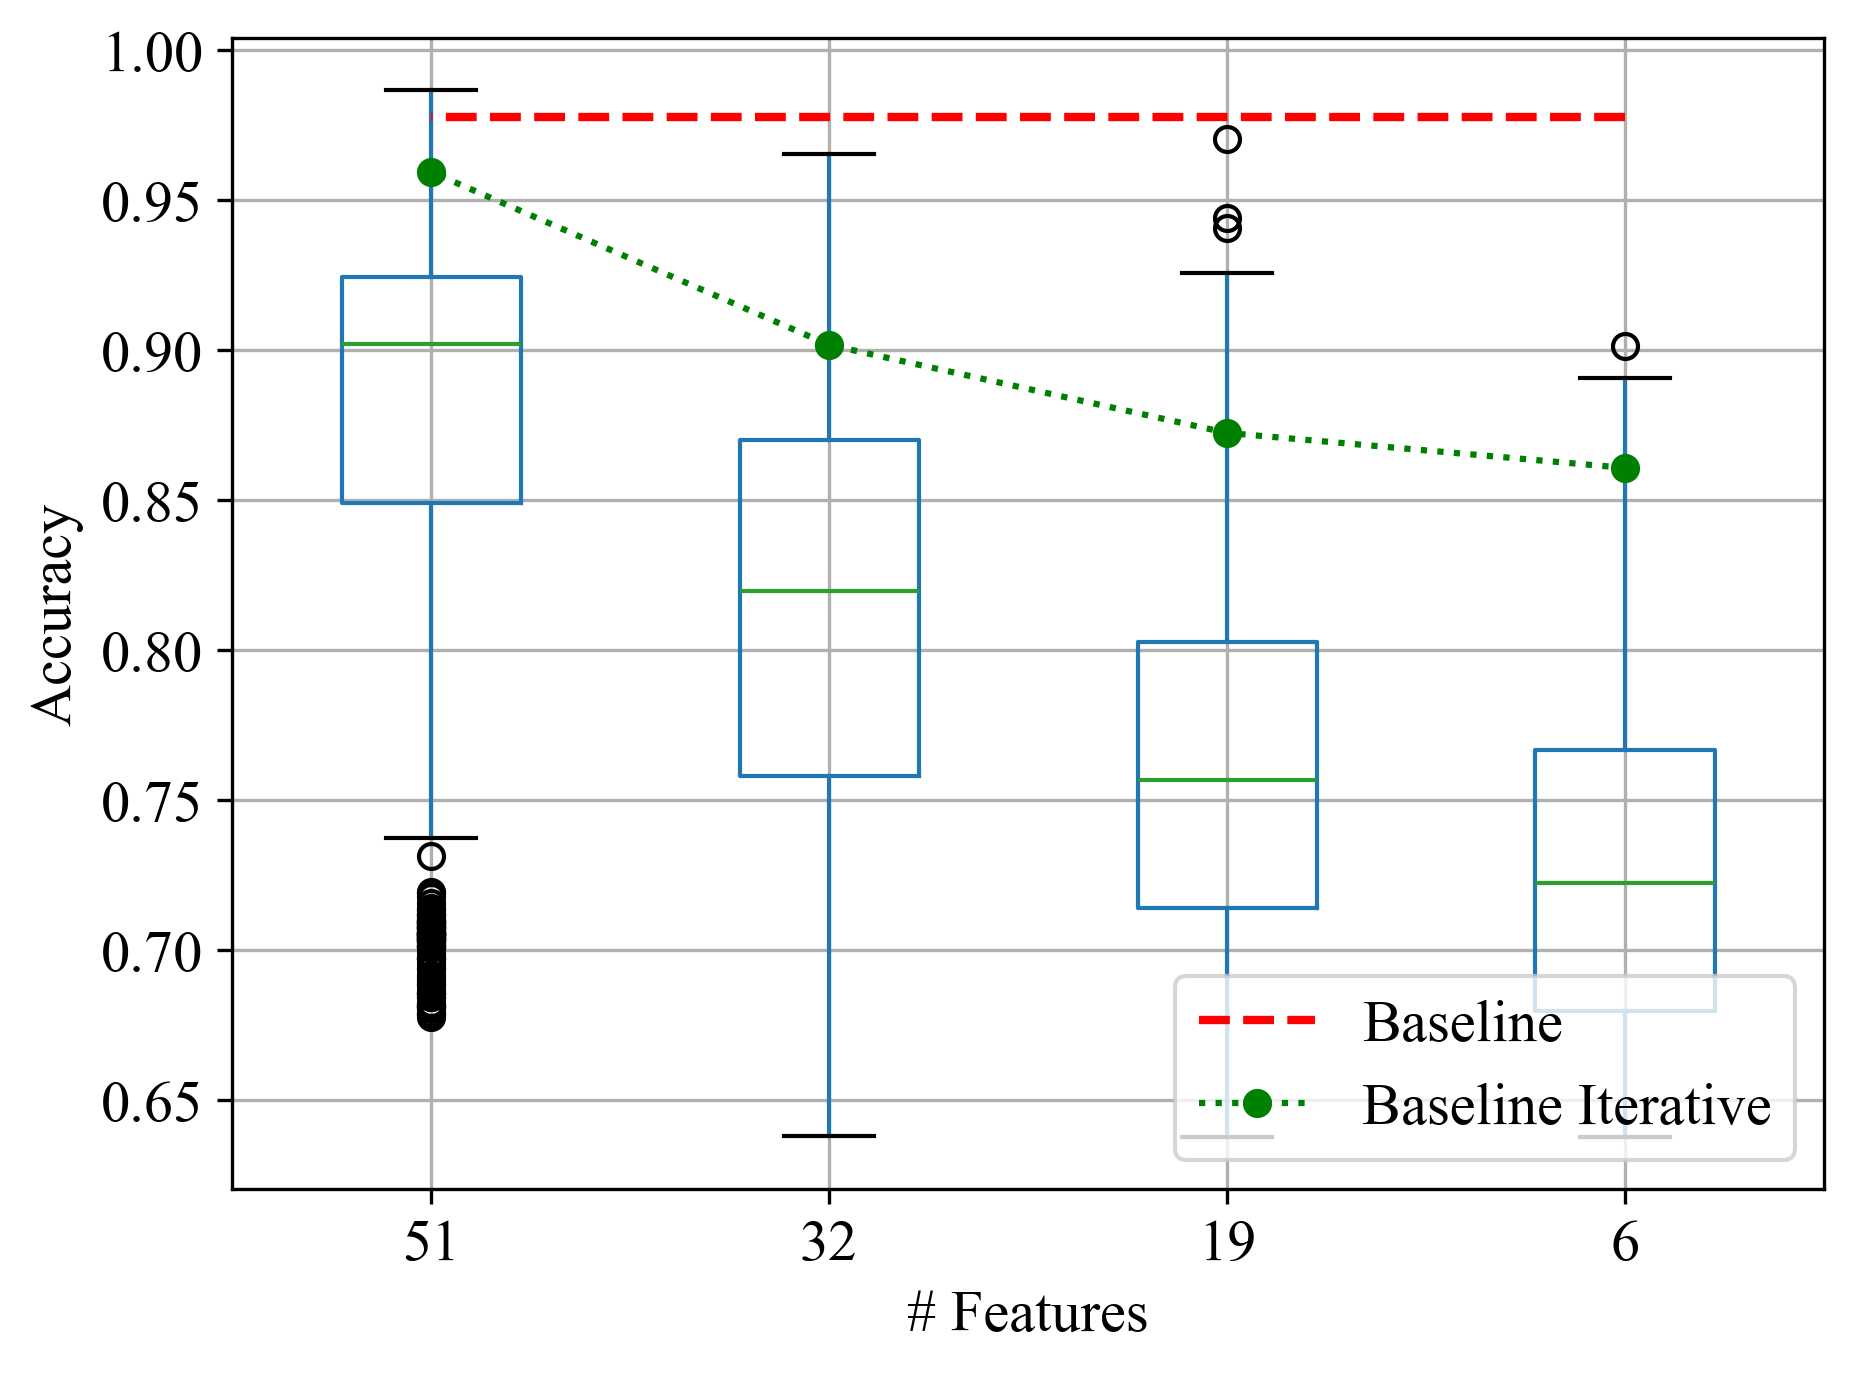

In [17]:
plot_different_pruning_and_subsets();

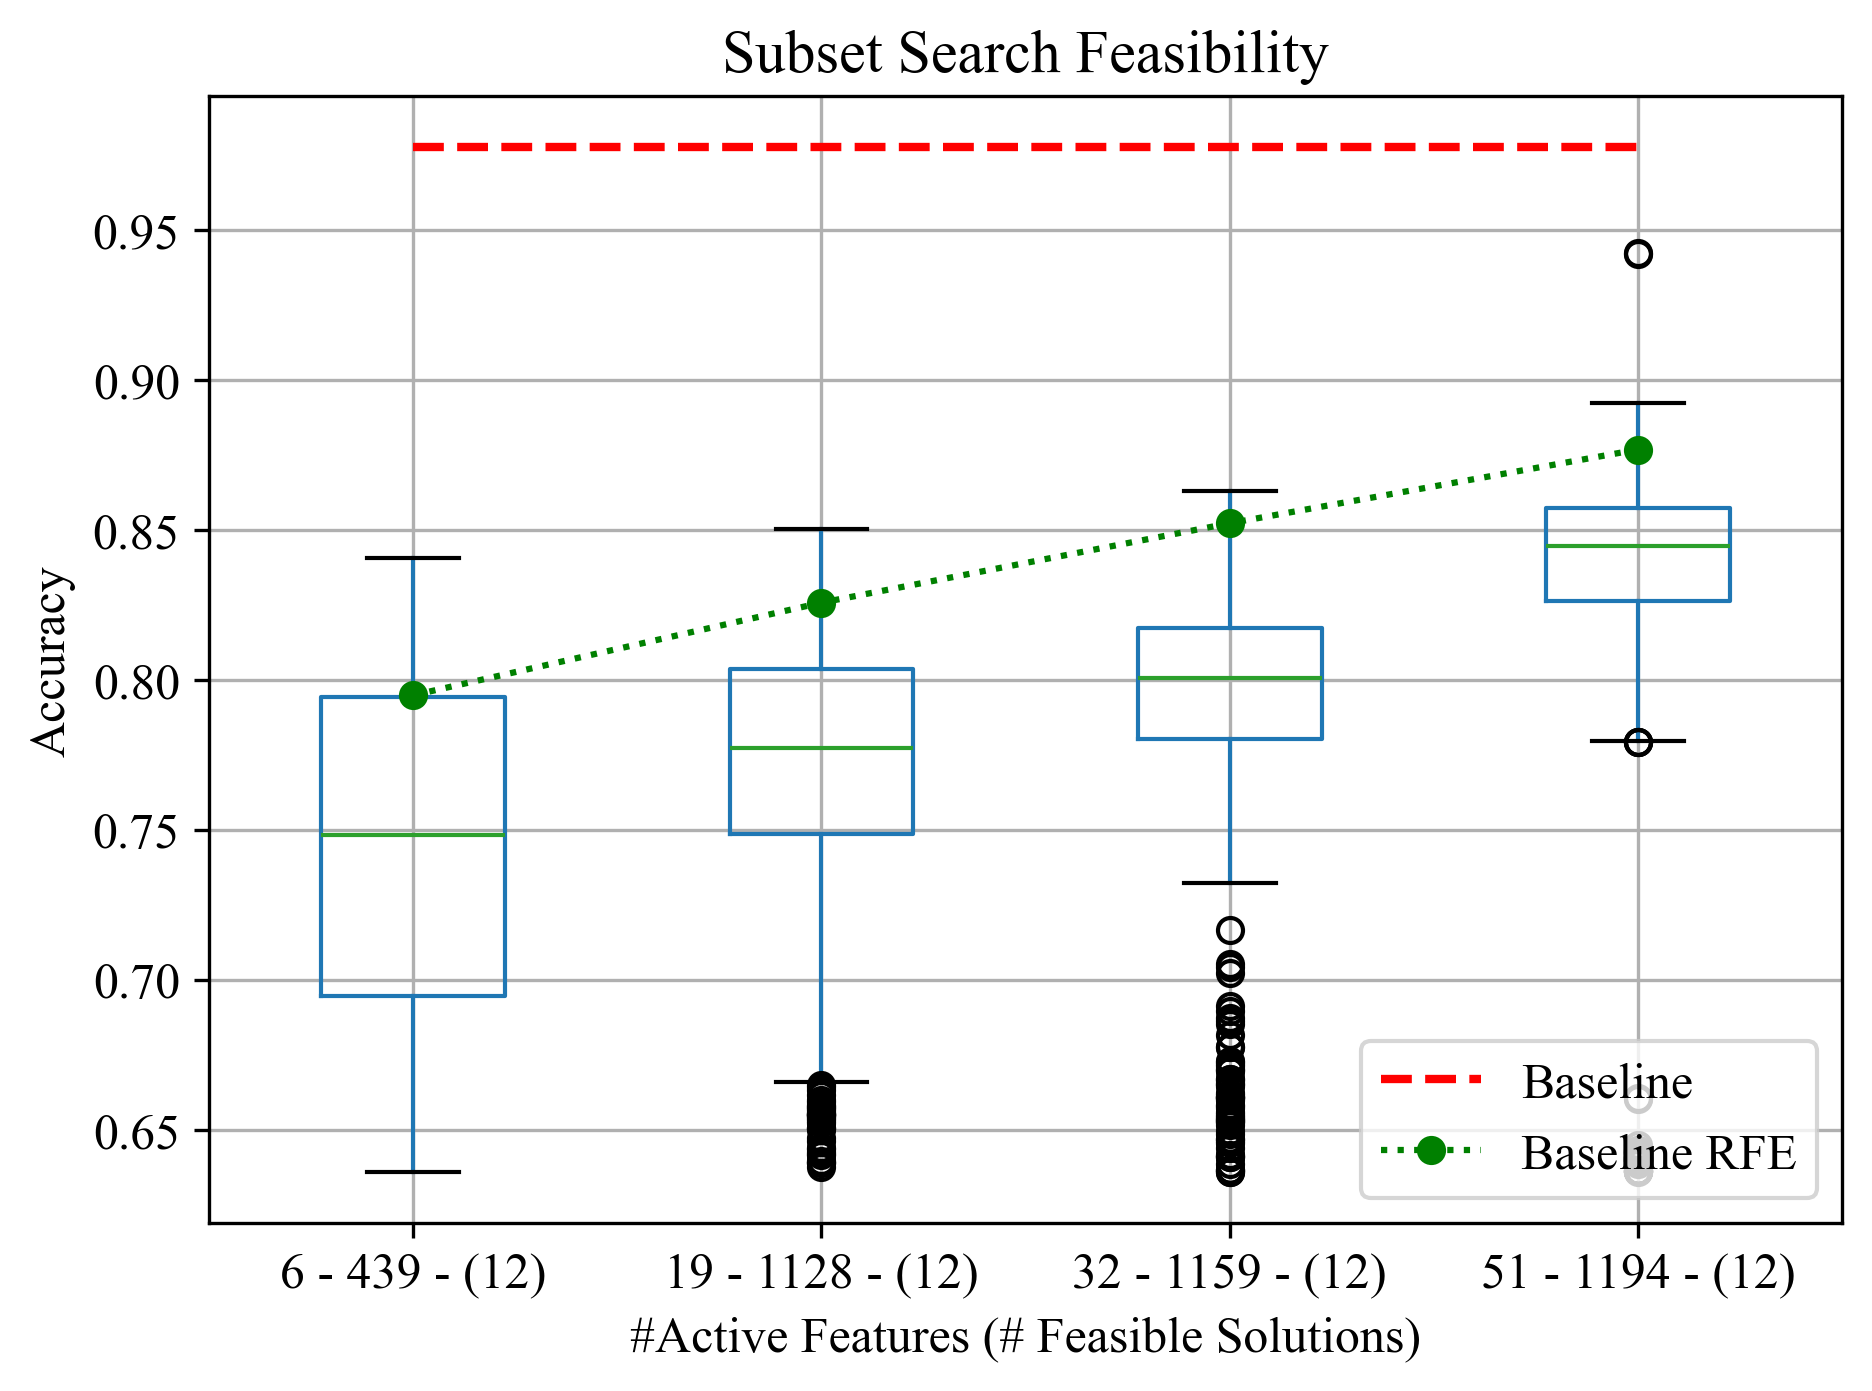

In [29]:
plot_different_pruning_and_subsets(all_categories=True);